In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from ndcg_calc import ndcg_calc
warnings.filterwarnings('ignore')

In [2]:
train_orig = pd.read_csv('processed_data/train_clean.csv')

In [3]:
# allocate a portion of the train set that's never used for training
#test = train_orig[len(train_orig)*2//3:]
test = train_orig[:len(train_orig)//2-1]
test = test.drop(['gross_bookings_usd','date_time','position','prop_desirability','booking_or_click_bool',
                 'prop_desirability_incomplete'], axis=1)

# set which columns are to be dropped from the initial dataset
cols_to_drop = ['booking_bool','click_bool','gross_bookings_usd','date_time','position','prop_desirability',
               'booking_or_click_bool','prop_desirability_incomplete']

# other possible column combinations to drop
#cols_to_drop = ['booking_bool','click_bool','gross_bookings_usd','date_time','position']
#cols_to_drop = ['booking_bool','click_bool','gross_bookings_usd','date_time']

In [4]:
# drop the columns and and make the training set
train = train_orig.drop(cols_to_drop, axis=1)[len(train_orig)//2-1:]

# free memory
train_orig = None
# fill nans with -999, skip this if you want to do something else with missing values
train.fillna(-999, inplace=True)

In [6]:
train.sort_values(by='srch_id', inplace=True)
labels = train.booked_clicked_combined
train.drop(['booked_clicked_combined'], inplace=True, axis=1)

In [7]:
# function to break srch_id's into folds 
def get_fold_ids(unique_srch_ids, num_folds=5):
    fraction = (len(unique_srch_ids)//num_folds)/len(unique_srch_ids)
    final_fold_ids = dict()
    for i in range(num_folds):
        num_samples = int(fraction*len(unique_srch_ids))
        train_sample_ids = np.random.choice(unique_srch_ids, num_samples, replace=False)
        unique_srch_ids = list(set(unique_srch_ids)-set(train_sample_ids))
        set_key = 'id_set' + str(i)
        final_fold_ids[set_key] = train_sample_ids
    return final_fold_ids

In [24]:
# divide ids into n subsets of equal size
num_folds = 3
fold_ids = get_fold_ids(train.srch_id.unique(),num_folds)
keys = list(fold_ids.keys())

In [38]:
models = []


parameter_range = [100,300,500]

scores = np.zeros((len(parameter_range),num_folds))
for i,param in enumerate(parameter_range):
    for k in range(num_folds):

        # divide the srch_ids into training and validation set
        id_valid  = k # validation set index
        valid_set_ids = fold_ids[keys[id_valid]] # get validation set ids
        
        if k == num_folds-1:
            train_set_ids = fold_ids[keys[0]]
        else:
            train_set_ids = fold_ids[keys[id_valid+1]]

        #get subsets of the full train set for training and validation sets
        valid_set = train[train.srch_id.isin(valid_set_ids)]
        train_set = train[~train.srch_id.isin(valid_set_ids)]

        #prepare the label 
        train_label = labels[train_set.index]
        valid_label = labels[valid_set.index]

        #get group data
        train_group = train_set.groupby(['srch_id']).size().values
        valid_group = valid_set.groupby(['srch_id']).size().values

        # put into lightGBM format
        lgb_train = lgb.Dataset(train_set,label=train_label, group=train_group)
        lgb_val = lgb.Dataset(valid_set, label=valid_label, group=valid_group)

        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'lambdarank',
            'metric': 'ndcg',
            'label_gain' : {0,1,5},
            'ndcg_at': 38,
            'num_leaves':10,
            'learning_rate': 0.1,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 1,
            'verbose': 0,
        }
        params['num_iterations'] = param

        # train the lambdarank model with given parameters
        lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val,
                              verbose_eval=100)
        models.append(lgbm_model)
        scores[i,k] = lgbm_model.best_score['valid_0']['ndcg@38']


#print('Average ndcg@38 score: {0:.8f}, std: {1:.8f}'.format(np.mean(scores),np.std(scores)))

KeyboardInterrupt: 

In [26]:
print(scores)

[[ 0.49113078  0.48876136  0.49369258]
 [ 0.49947732  0.49833608  0.5037256 ]
 [ 0.50198132  0.50092592  0.50685491]]


In [27]:

mean_scores = np.mean(scores, axis=1)
print(mean_scores)

[ 0.49119491  0.500513    0.50325405]


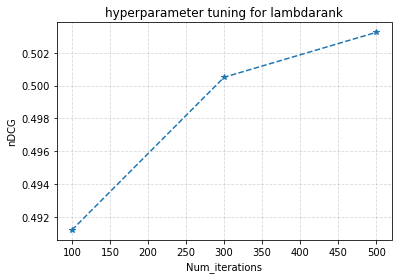

In [28]:
x_str = 'Num_iterations'
plt.figure()
plt.plot(parameter_range, mean_scores,marker='*',linestyle='--')
plt.xlabel(x_str)
plt.ylabel('nDCG')
plt.title('hyperparameter tuning for lambdarank')
plt.grid(color='gray',alpha=0.3, linestyle='--')
#plt.xticks(np.arange(min(parameter_range), max(parameter_range)+100))
#plt.savefig('titanic_LRtuning.pdf',bbox_inches='tight')

In [27]:
#test = test.fillna(-999)

In [29]:
test_scores = np.zeros(len(models))
for i,model in enumerate(models):
    ypred = model.predict(test)
    test_score = ndcg_calc(test[['srch_id','click_bool','booking_bool']], ypred)
    test_scores[i] = test_score
    print('Model {0:d} score is {1:.8f}'.format(i, test_score))

Model 0 score is 0.43203613
Model 1 score is 0.43014027
Model 2 score is 0.43436309
Model 3 score is 0.43203961
Model 4 score is 0.43250127
Model 5 score is 0.42567046
Model 6 score is 0.41190959
Model 7 score is 0.41944116
Model 8 score is 0.39948539


In [30]:
test_scores = test_scores.reshape((len(parameter_range),num_folds))
test_scores

In [31]:
mean_test_scores = np.mean(test_scores, axis=1)
mean_test_scores

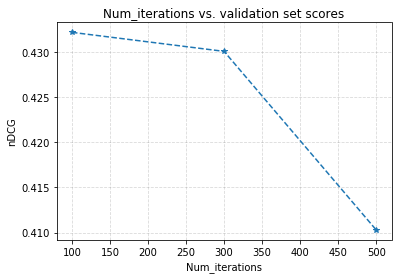

In [33]:
#mean_test_scores = np.mean(test_scores, axis=1)
plt.figure()
plt.plot(parameter_range, mean_test_scores, marker='*', linestyle='--')
plt.xlabel(x_str)
plt.ylabel('nDCG')
plt.title('Num_iterations vs. validation set scores')
plt.grid(color='gray',alpha=0.3, linestyle='--')
#plt.xticks(np.arange(min(parameter_range), max(parameter_range)+100,))
plt.savefig("output/num_iterations_vs_ndcg_small.pdf", bbox_inches='tight')

In [36]:
feature_importances = dict(zip(models[-1].feature_name(), models[-1].feature_importance()))
feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
feature_importances

[('prop_log_historical_price', 439),
 ('price_usd_norm_srch_id', 439),
 ('price_usd', 391),
 ('prop_location_score2_norm_srch_destination_id', 385),
 ('prop_location_score2_norm_srch_id', 266),
 ('prop_location_score1', 249),
 ('prop_starrating', 218),
 ('srch_query_affinity_score', 214),
 ('prop_location_score1_norm_srch_id', 153),
 ('prop_review_score_norm_srch_id', 139),
 ('prop_location_score2', 132),
 ('prop_review_score', 115),
 ('prop_review_score_norm_srch_destination_id', 107),
 ('star_diff_filled', 106),
 ('price_usd_norm_srch_destination_id', 104),
 ('random_bool', 102),
 ('prop_location_score1_norm_srch_destination_id', 95),
 ('price_diff_filled', 93),
 ('orig_destination_distance', 87),
 ('price_diff', 79),
 ('prop_id', 78),
 ('prop_country_id', 77),
 ('promotion_flag', 75),
 ('srch_booking_window', 54),
 ('prop_brand_bool', 51),
 ('visitor_hist_starrating_filled', 25),
 ('visitor_location_country_id', 24),
 ('visitor_hist_adr_usd_filled', 22),
 ('srch_length_of_stay', 21)